# Sentiment Analysis with BERT (Week 12)

> In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/): this lab is prepared with this tutorial.
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

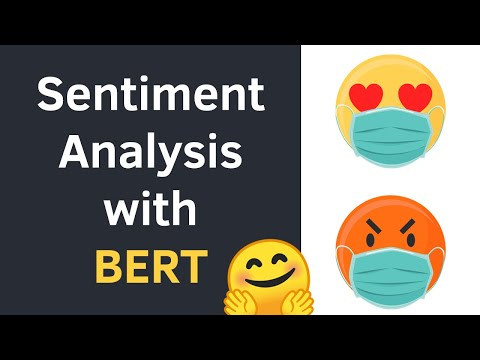

In [1]:
# Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('8N-nM3QW7O0', width=720, height=420)

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the encoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:
- watermark: An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
- IPython is an interactive shell that is built with python. It provides a more useful shell environment to execute python code in REPL (Read Eval Print Loop). It makes it more interactive by adding features like syntax highlighting, code completion etc. IPython also comes with other tools like Jupyter Notebooks etc. 

In [2]:
# -q -qq, or -qqq: give less output
# -U: Upgrade all specified packages to the newest available version.
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

     |████████████████████████████████| 3.1 MB 7.5 MB/s 
     |████████████████████████████████| 596 kB 61.2 MB/s 
     |████████████████████████████████| 895 kB 61.9 MB/s 
     |████████████████████████████████| 3.3 MB 56.0 MB/s 
     |████████████████████████████████| 59 kB 8.8 MB/s 


In [4]:
# load watermark
# -v: prints Python and IPython version; -p: prints versions of packages
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.9.0+cu111
transformers: 4.12.3



In [5]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
print(device)

cuda


## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [8]:
# install gdown first for downloading a large file from Google Drive: pip install gdown
!gdown --id 1zWI0A4bE1p9fm-ROxAdTWW_xlV04dW6P
# !gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1zWI0A4bE1p9fm-ROxAdTWW_xlV04dW6P
To: /content/Corona_NLP_all_splits.csv
100% 10.1M/10.1M [00:00<00:00, 47.4MB/s]


In [9]:
df = pd.read_csv("Corona_NLP_all_splits.csv")
df.head()
# df.head()
# df = pd.read_csv("reviews.csv")

,Sentiment,OriginalTweet,split
0,Extremely Negative,CONSUMERS: @EU_Consumer and national authoriti...,train
1,Extremely Negative,So awful that people are having to self isolat...,train
2,Extremely Negative,Did anyone hear in the budget a pledge to help...,train
3,Extremely Negative,Could this #coronavirus crisis be a tipping po...,train
4,Extremely Negative,Cons want to focus on saving corps &amp; busin...,train


In [10]:
df.shape

(44953, 3)

We have about 16k examples. Let's check for missing values:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44953 entries, 0 to 44952
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      44953 non-null  object
 1   OriginalTweet  44953 non-null  object
 2   split          44953 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [12]:
def clean_tweet(tweet):

    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    temp = temp.split()
    temp = " ".join(word for word in temp)
    return temp

In [13]:
df['OriginalTweet'] = df['OriginalTweet'].apply(clean_tweet)

Great, no missing values in the score and review texts! Do we have class imbalance?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


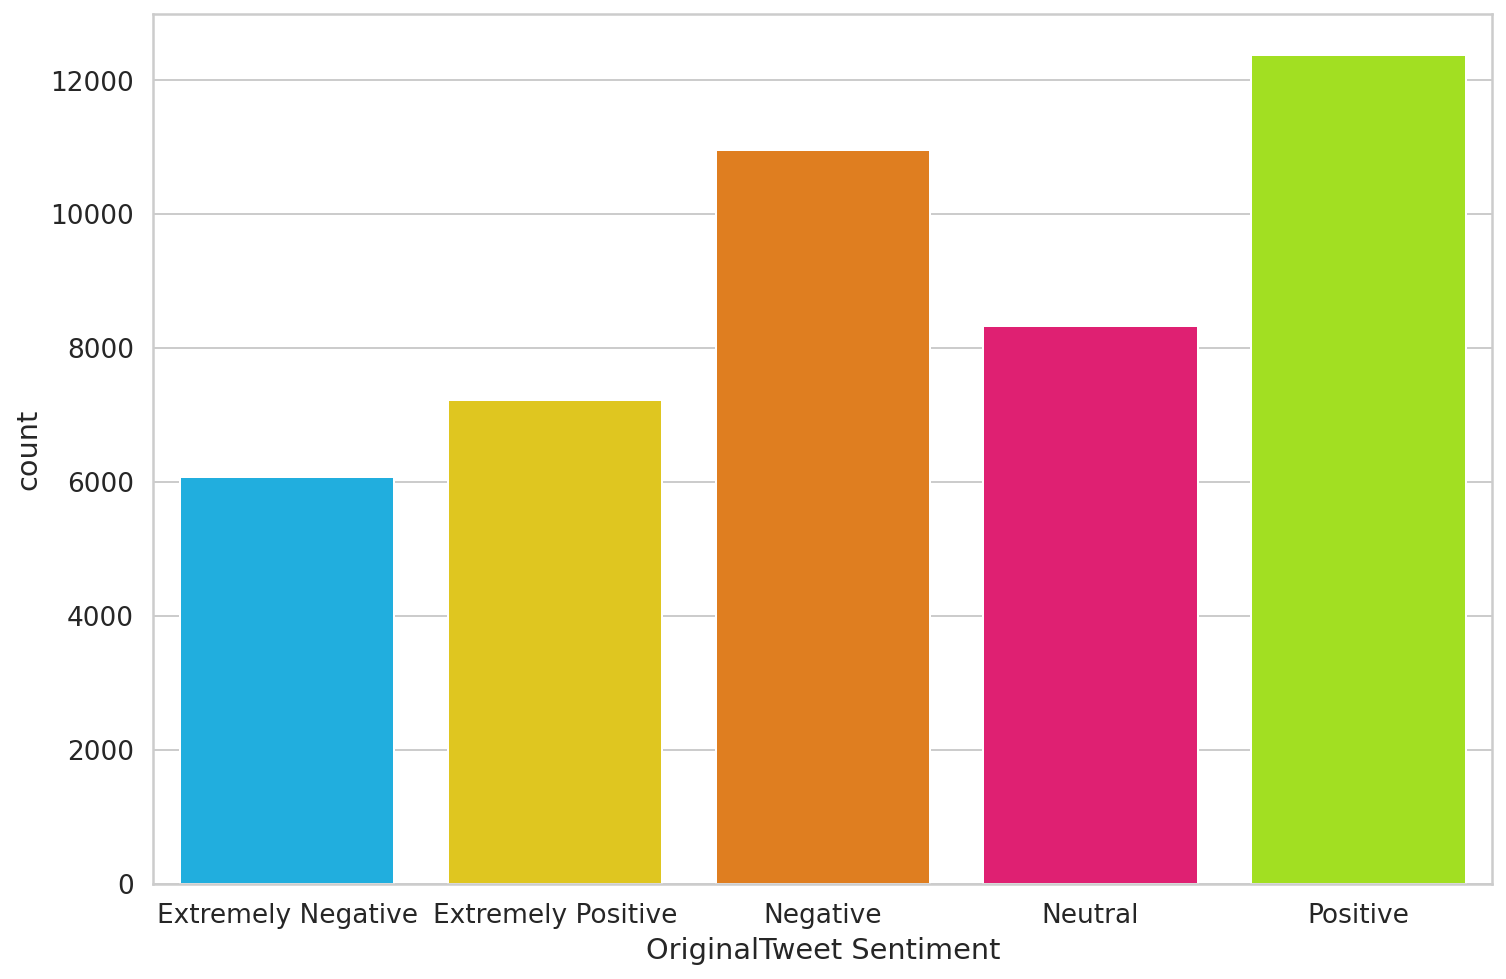

In [14]:
sns.countplot(df.Sentiment)
plt.xlabel('OriginalTweet Sentiment');

In [15]:
labels = {j:i for i,j in enumerate(df.Sentiment.unique().tolist())}
print(labels)

{'Extremely Negative': 0, 'Extremely Positive': 1, 'Negative': 2, 'Neutral': 3, 'Positive': 4}


In [16]:
df['sentiment'] = df.Sentiment.map(labels)
df['content'] = df.OriginalTweet

In [17]:
class_names = [i for i,j in labels.items()]
print(class_names)

['Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


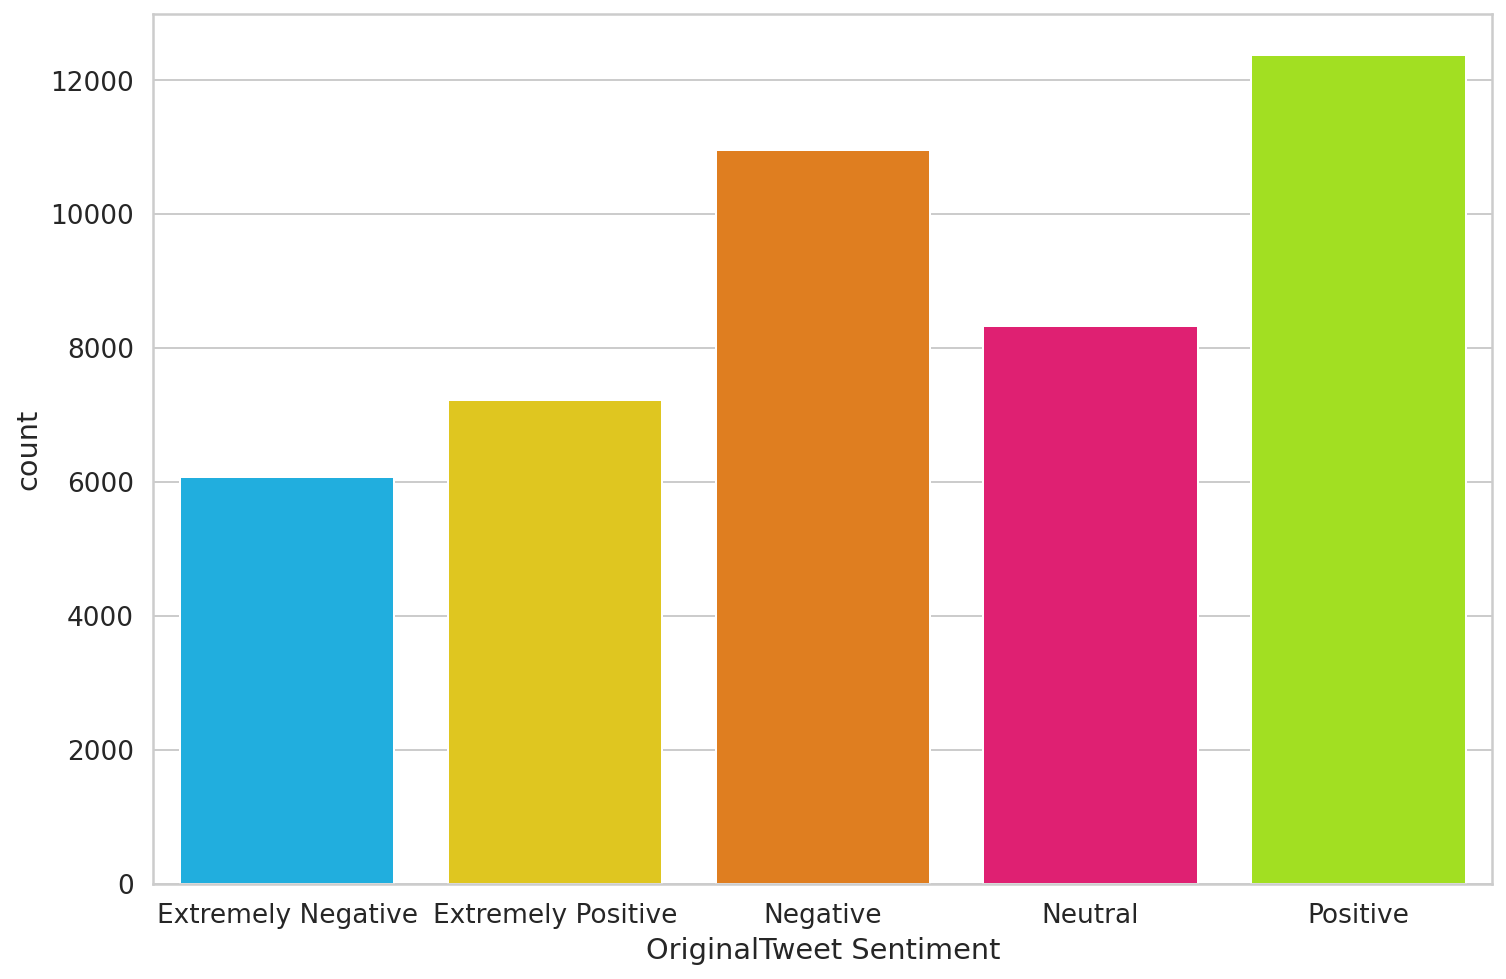

In [18]:
ax = sns.countplot(df.sentiment)
plt.xlabel('OriginalTweet Sentiment')
ax.set_xticklabels(class_names);

The balance was (mostly) restored.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [19]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'  # E.g., bert-base-uncased, bert-large-cased, bert-large-uncased, etc.

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [20]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

We'll use this text to understand the tokenization process:

In [21]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [22]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [23]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [24]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [25]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [26]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

- The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value. This attention mask is in the dictionary returned by the tokenizer under the key “attention_mask”:

In [27]:
encoding = tokenizer.encode_plus(
  sample_txt,       # 'When was I last outside? I am stuck at home for 2 weeks.' (15 tokens)
  truncation=True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,   #  used for a pair of sentences, also called segment IDs.
  padding='max_length',          #  Pad to a maximum length
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [28]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [29]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [30]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'i',
 'last',
 'outside',
 '?',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [31]:


token_lens = []

for txt in df.content:
  if pd.isna(txt):continue
  tokens = tokenizer.encode(txt, max_length=512, truncation=True) # without padding
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


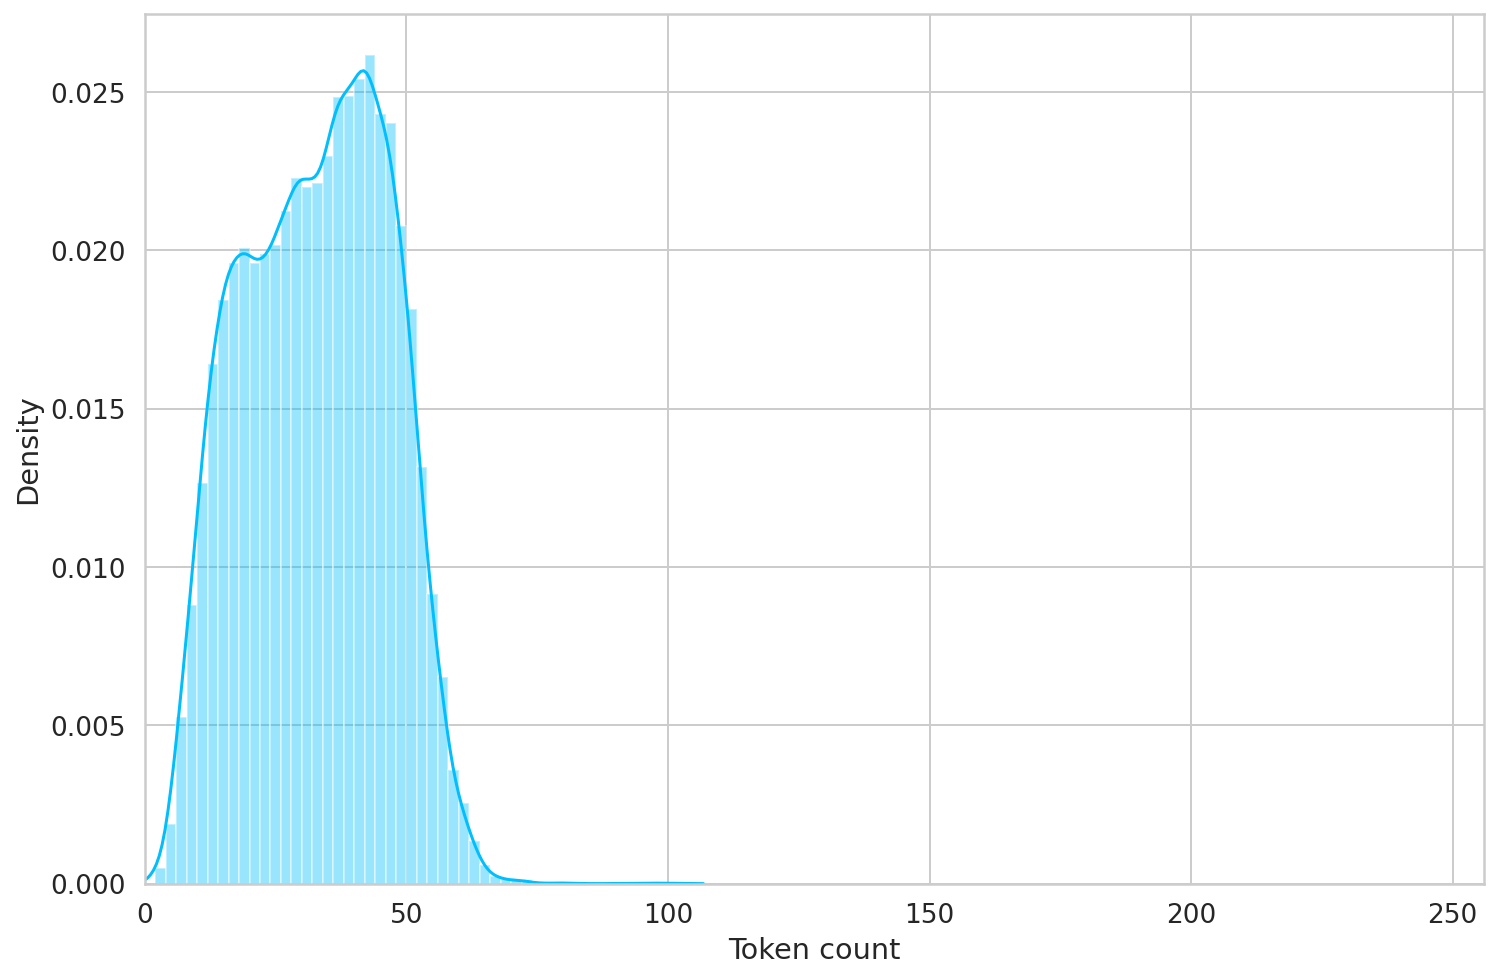

In [32]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [33]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [34]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews    # df.content
    self.targets = targets    # df.sentiment
    self.tokenizer = tokenizer
    self.max_len = max_len    # 160
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])    # E.g., "Update: After getting a response from the deve..."
    target = self.targets[item]         # E.g., 0 (negative)

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,                                    # "Update: After getting a response from the deve..."
      'input_ids': encoding['input_ids'].flatten(),             # [101, 34, 54, 37, ..., 102, 0, 0, ..., 0]
      'attention_mask': encoding['attention_mask'].flatten(),   # [1,    1,  1,  1, ...,   1, 0, 0, ..., 0]
      'targets': torch.tensor(target, dtype=torch.long)         # 0
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [35]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [36]:
df_train.shape, df_val.shape, df_test.shape

((31467, 5), (6743, 5), (6743, 5))

We also need to create a couple of data loaders. Here's a helper function to do it:
- Truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided. 

In [37]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  print(df.content.to_numpy())
  print(df.sentiment.to_numpy())
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4 #  process hangs with num_workers=4
    num_workers=0  #  num_workers: how many subprocesses to use for data loading. 0 means that the data will be 
                   #  loaded in the main process. (default: 0)
  )

In [38]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

['it seems smart for one of the large streaming services to slash prices in half for 3 months tagline save lives stay in and binge this is weirdly a perfect time for streaming services to step up and help communicate'
 'were officially up amp running with production of isolation gowns here in ns its only day 1 of this necessary retooling but we want to take the time to thank all of the amazing people helping to make this happen'
 'so all this fuss is supposed to protect the elderly yet the overreacting is making it worse elderly australian woman left in tears at empty supermarket shelves amid pleas to stop hoarding food'
 ...
 'never in a million years i d have thought i d have been queuing at a supermarket store like this and wearing a mask please everyone stick to the rules and stay in home unless absolutely essential'
 'the pandemic is changing situations by the hour in the face of a crisis you need to adjust your marketing amp adapt to changing consumer needs read on to discover ho

Let's have a look at an example batch from our training data loader:

In [39]:
data = next(iter(train_data_loader))  # first batch from train data
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [40]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [41]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


And try to use it on the encoding of our sample text: <b>'When was I last outside? I am stuck at home for 2 weeks.'</b>

In [42]:
outputs = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooler_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [43]:
outputs.last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [44]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [45]:
outputs.pooler_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [46]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(outputs.pooler_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [47]:
print(len(class_names))
model = SentimentClassifier(len(class_names))   # class_names = ['negative', 'neutral', 'positive']
model = model.to(device)

5


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We'll move the example batch of our training data to the GPU or CPU:

In [48]:
input_ids = data['input_ids'].to(device)            # data contains the first batch of train data
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [49]:
F.softmax(model(input_ids, attention_mask), dim=1)  # apply to the model without training

tensor([[0.1001, 0.0832, 0.1287, 0.1566, 0.5314],
        [0.1347, 0.1005, 0.1246, 0.1551, 0.4850],
        [0.1123, 0.1194, 0.1364, 0.1629, 0.4690],
        [0.0651, 0.0938, 0.1307, 0.1432, 0.5672],
        [0.0981, 0.1469, 0.1542, 0.2120, 0.3887],
        [0.1100, 0.1187, 0.1225, 0.1427, 0.5060],
        [0.1751, 0.1252, 0.2127, 0.1644, 0.3226],
        [0.1583, 0.1153, 0.2770, 0.1439, 0.3055],
        [0.1621, 0.1373, 0.1595, 0.2406, 0.3005],
        [0.1563, 0.1418, 0.1763, 0.1582, 0.3674],
        [0.1124, 0.1242, 0.1862, 0.2211, 0.3560],
        [0.1984, 0.0877, 0.1976, 0.1792, 0.3371],
        [0.0630, 0.1122, 0.1091, 0.1811, 0.5346],
        [0.0680, 0.0966, 0.1229, 0.1908, 0.5217],
        [0.1165, 0.1492, 0.2014, 0.1371, 0.3958],
        [0.1572, 0.0643, 0.1053, 0.1878, 0.4854]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps: https://huggingface.co/transformers/main_classes/optimizer_schedules.html
- [get_linear_schedule_with_warmup()](https://huggingface.co/transformers/main_classes/optimizer_schedules.html): Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [50]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS       # number of batches in training data * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [51]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)   # Clips gradients of an iterable of parameters.
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7066832798905766 accuracy 0.7217402358025868
Val   loss 0.430018664889426 accuracy 0.8439863562212664

Epoch 2/10
----------
Train loss 0.355998274778363 accuracy 0.875615724409699
Val   loss 0.3996804247045298 accuracy 0.8628207029512086

Epoch 3/10
----------
Train loss 0.2589951317970905 accuracy 0.9168017287952458
Val   loss 0.5607514129046757 accuracy 0.8537742844431261

Epoch 4/10
----------
Train loss 0.19953842936080124 accuracy 0.9409222359932627
Val   loss 0.6083693078065829 accuracy 0.858668248554056

Epoch 5/10
----------
Train loss 0.15650348728754068 accuracy 0.9557314011504114
Val   loss 0.6738913710336962 accuracy 0.8648969301497849

Epoch 6/10
----------
Train loss 0.11906463886836892 accuracy 0.9688244827914958
Val   loss 0.7098577936670701 accuracy 0.8694942903752039

Epoch 7/10
----------
Train loss 0.09506093056203528 accuracy 0.9756252582070104
Val   loss 0.7214466538170592 accuracy 0.8723120272875574

Epoch 8/10
----------
Train

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

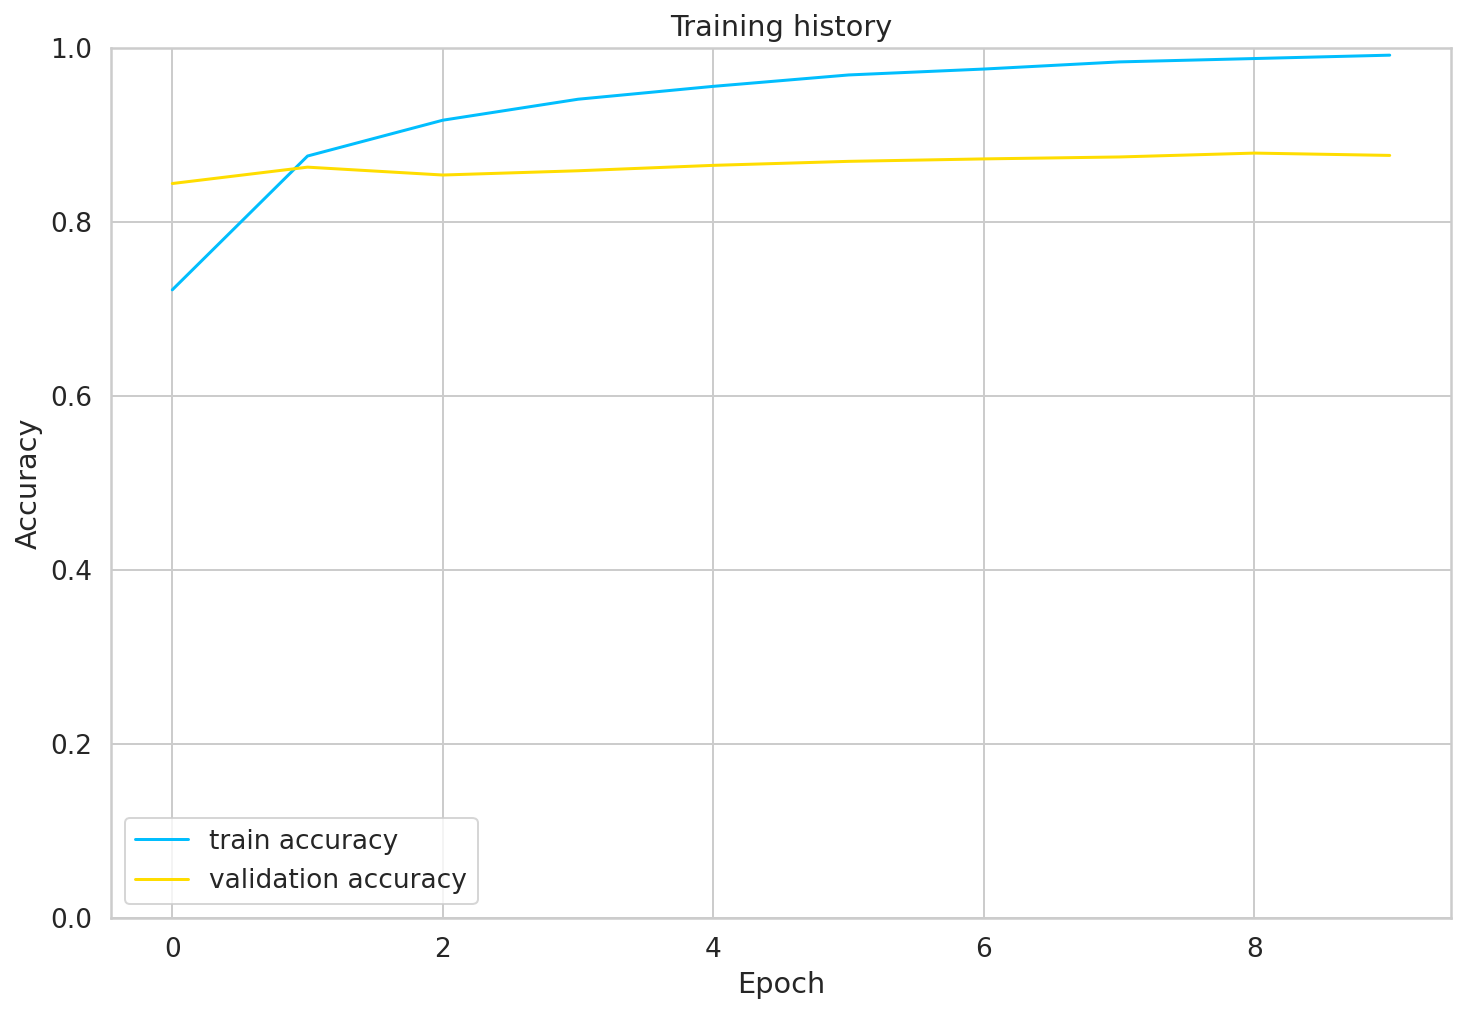

In [54]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

- For loading the model trained on a gpu machine on a cpu device, need to use map_location=torch.device('cpu').

In [55]:
# possible to use a local machine with the pre-trained model, instead of using colab

# model = SentimentClassifier(len(class_names)) # uncomment this line
# model.load_state_dict(torch.load('model/best_model_state.bin', map_location=torch.device('cpu'))) # uncomment this line for cpu machine
# model.load_state_dict(torch.load('model/best_model_state.bin')) # or uncomment this line for gpu machine
# model = model.to(device) # uncomment this line

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [56]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

test_acc.item()

0.8749814622571555

The accuracy is about 1% higher on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [57]:
def get_predictions(model, data_loader):
  
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Let's have a look at the classification report

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names))

                    precision    recall  f1-score   support

Extremely Negative       0.87      0.92      0.89       948
Extremely Positive       0.90      0.90      0.90      1096
          Negative       0.88      0.84      0.86      1600
           Neutral       0.84      0.91      0.87      1266
          Positive       0.89      0.85      0.87      1833

          accuracy                           0.87      6743
         macro avg       0.87      0.88      0.88      6743
      weighted avg       0.88      0.87      0.87      6743



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

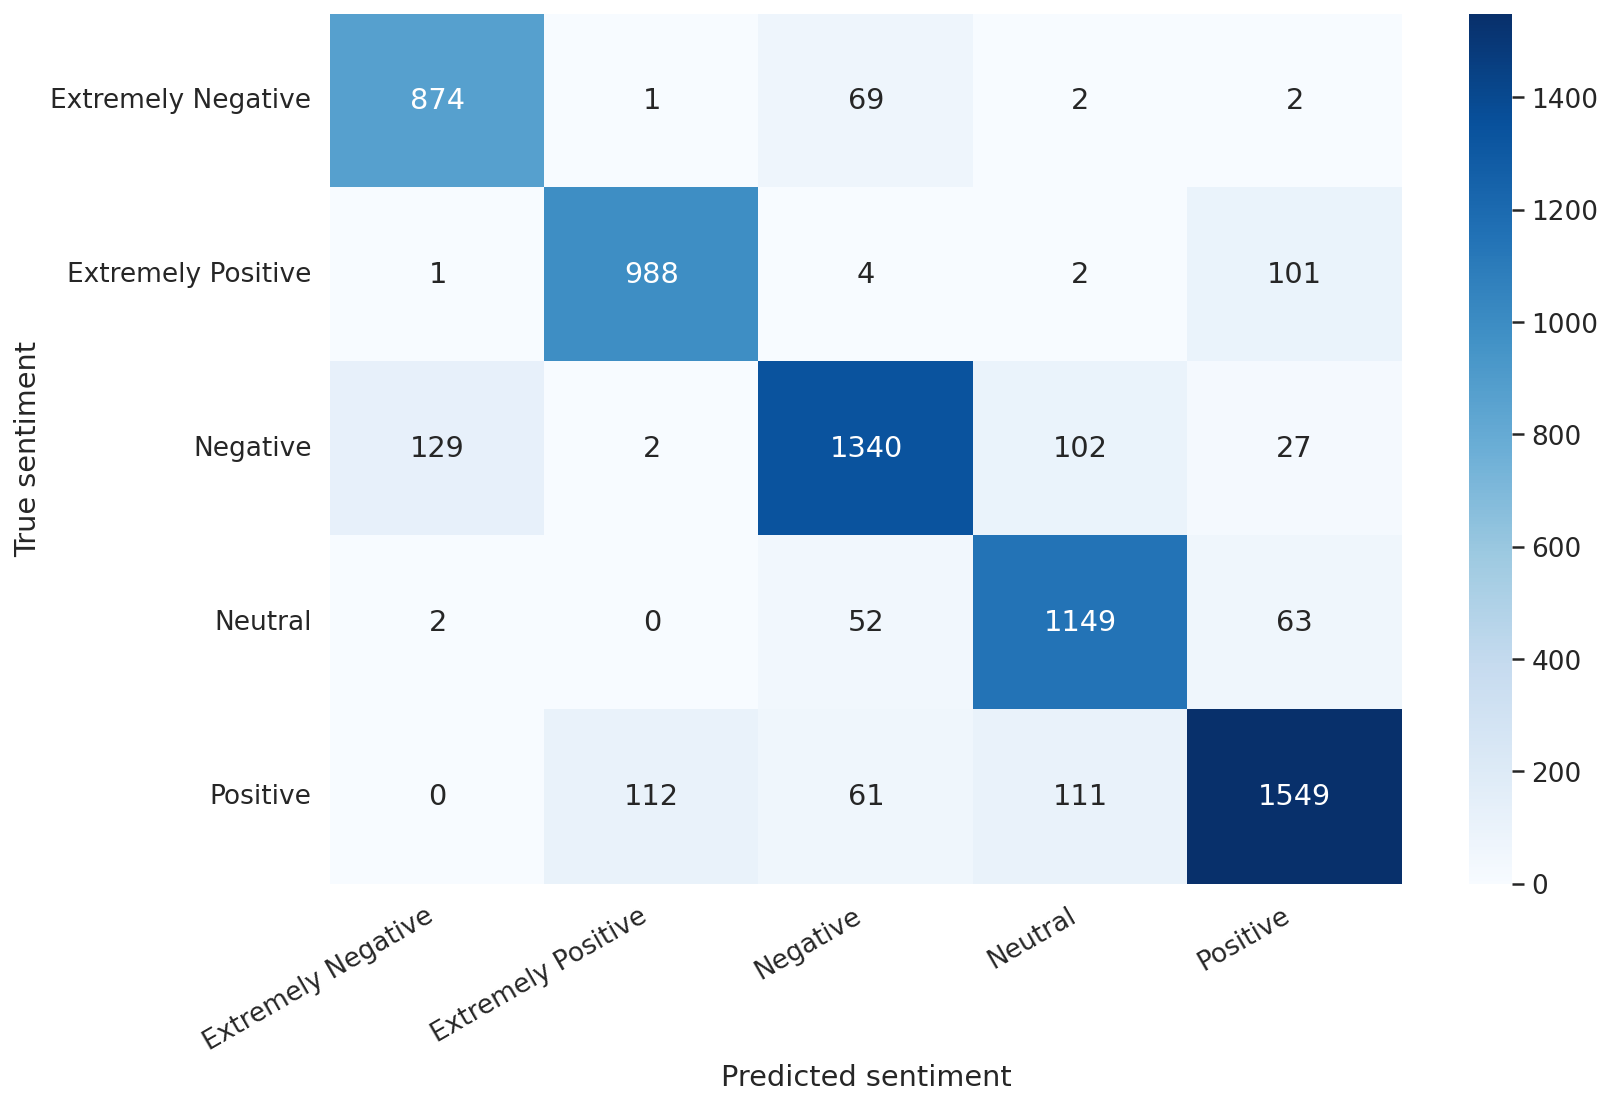

In [60]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [61]:
idx = 2

review_text = y_review_texts[idx]     # review text in test data
true_sentiment = y_test[idx]          # true sentiment
pred_df = pd.DataFrame({
  'class_names': class_names,         # class_names = ['negative', 'neutral', 'positive']
  'values': y_pred_probs[idx]         #         E.g., [0.05, 0.9, 0.05]
})

In [62]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

twisted prank woman purposely coughed on 35 000 worth of food at a
supermarket in pennsylvania

True sentiment: Positive


Now we can look at the confidence of each sentiment of our model:

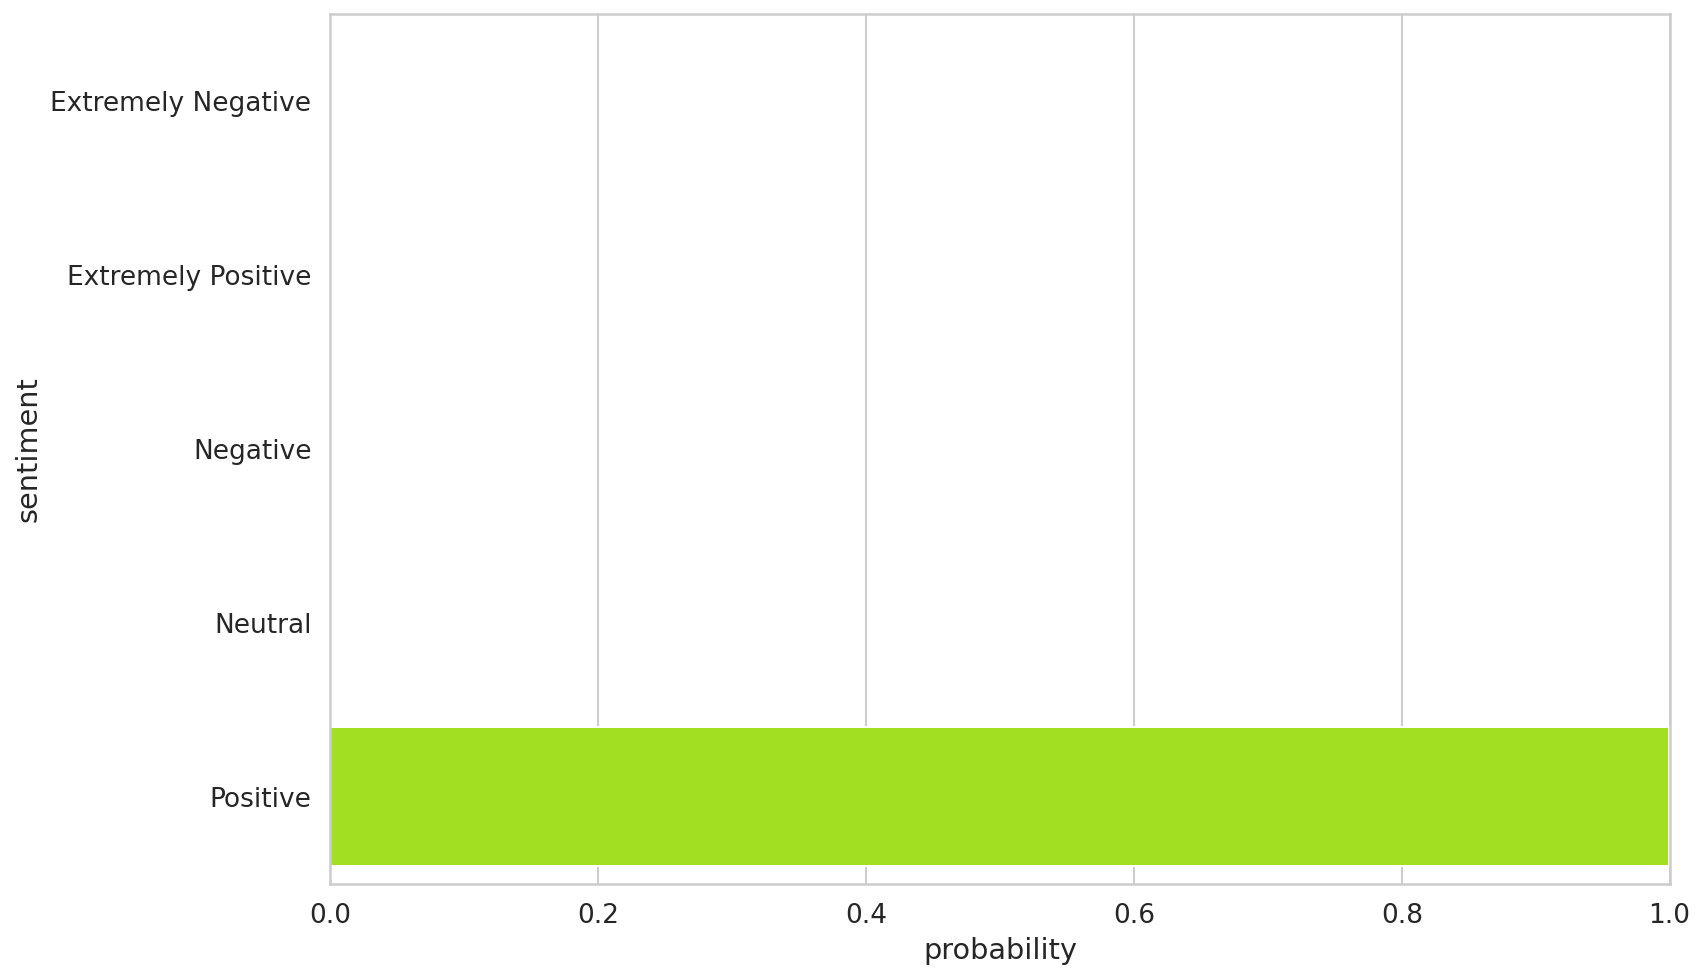

In [63]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

We have to use the tokenizer to encode the text:

- truncation: Truncate to a maximum length specified with the argument max_length or to the maximum acceptable input length for the model if that argument is not provided. 

Let's get the predictions from our model:

In [64]:
def predict(review):
  encoded_review = tokenizer.encode_plus(
    review,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f'Review text: {review}')
  print(f'Sentiment  : {class_names[prediction]}')
  print('\n')

In [65]:
predict('covid has got our family together i am so happy')
predict('covid has got our family together i am happy')
predict('I have Text & Web Mining lesson tonight')
predict("I hate covid it is very bad here")
predict("I hate covid")

Review text: covid has got our family together i am so happy
Sentiment  : Extremely Positive


Review text: covid has got our family together i am happy
Sentiment  : Positive


Review text: I have Text & Web Mining lesson tonight
Sentiment  : Neutral


Review text: I hate covid it is very bad here
Sentiment  : Extremely Negative


Review text: I hate covid
Sentiment  : Negative




## Summary

You learned how to use BERT for sentiment analysis. You built a custom classifier using the Hugging Face library and trained it on our app reviews dataset!

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)